# Ch 3 — Why orientation is not a single 3D vector (SO(3) intuition)

## Key questions answered
1. Why do we learn Rotation matrix?
2. Why is it not a vector?

## Key techniques used
- **Rotation matrices** \(R \in SO(3)\)
- **Axis–angle representation**
- **Rodrigues’ rotation formula**

These tools will later generalize to **SE(3)** (rigid-body transformations),
**twists**, **Jacobians**, and **inverse kinematics**.


## What you’ll see

This notebook shows a **concrete ambiguity**:

- A single **unit direction vector** (e.g., "forward") has only **2 DoF** (it lives on a sphere S²).
- A 3D orientation has **3 DoF** (it lives on **SO(3)**).
- Therefore, many different orientations can share the same forward direction.

We create two rigid-body poses:

- Both have the same **forward axis** (blue).
- One is **rolled** around that forward axis by 90°.
- The rigid “camera plate” makes the roll visually obvious.

## Concepts used
- **Body frame vs space/world frame**
- **Rotation matrix** `R ∈ SO(3)` as a full orientation
- **Axis–angle / Rodrigues**: rolling by rotating about the forward axis

## Links
- Modern Robotics (Chapter 3: Rigid-Body Motions): https://modernrobotics.northwestern.edu/chapters/chapter3/
- Repo note: `notes/ch03_rigid_body_motions.md`
- Next notebooks:
  - `notebooks/ch03_so3_rotation.ipynb`
  - `notebooks/ch03_twist_se3.ipynb`


## Keywords used in the notebook

- **SO(3)**: the set of all **3×3 rotation matrices** (valid 3D orientations).  
  Properties: `RᵀR = I` and `det(R) = 1`.

- **S²**: the set of all **unit direction vectors** in 3D (a sphere).  
  This is enough to represent a **pointing direction** (e.g., “forward”), but not roll.

- **Roll**: a rotation **about the forward axis** (spin like turning a steering wheel).  
  Roll changes the “twist” of the body without changing where it points.

- **World / Space frame**: a **fixed reference coordinate frame** (the room / lab axes).

- **Body frame**: a coordinate frame **attached to the object**, moving with it.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def normalize(v):
    v = np.array(v, dtype=float)
    return v / np.linalg.norm(v)

def hat(w):
    wx, wy, wz = w
    return np.array([[0, -wz, wy],
                     [wz, 0, -wx],
                     [-wy, wx, 0]], dtype=float)

def rodrigues(axis, theta):
    axis = normalize(axis)
    W = hat(axis)
    I = np.eye(3)
    return I + np.sin(theta)*W + (1-np.cos(theta))*(W@W)

def make_frame_from_forward_up(fwd, up_hint):
    """
    Construct an orientation frame given a forward direction and an up hint.
    This mimics a "look-at" camera: fwd defines z-axis, then choose x/y based on up_hint.
    """
    z = normalize(fwd)
    up_hint = normalize(up_hint)
    x = np.cross(up_hint, z)
    if np.linalg.norm(x) < 1e-8:
        raise ValueError("up_hint is parallel to forward; choose a different up_hint")
    x = normalize(x)
    y = np.cross(z, x)
    R = np.column_stack([x, y, z])  # columns are x,y,z axes
    return R

def draw_frame(ax, R, p=np.zeros(3), L=1.0, label=None):
    colors = ['r','g','b']
    for i in range(3):
        v = R[:, i] * L
        ax.quiver(p[0], p[1], p[2], v[0], v[1], v[2], color=colors[i], linewidth=2)
    if label:
        ax.text(p[0], p[1], p[2], label)

# ---- Demo: same forward vector, different roll => different orientation ----
fwd = np.array([1.0, 0.0, 0.0])          # "pointing along +x"
up  = np.array([0.0, 0.0, 1.0])          # world up

R0 = make_frame_from_forward_up(fwd, up) # base orientation

# Roll about forward axis by 90 degrees
R_roll90 = rodrigues(fwd, np.pi/2) @ R0

print("Forward axis (z-axis) of both frames:")
print("R0 z =", R0[:,2].round(3))
print("R_roll90 z =", R_roll90[:,2].round(3))
print("\nAre the full rotations equal?", np.allclose(R0, R_roll90))


Forward axis (z-axis) of both frames:
R0 z = [1. 0. 0.]
R_roll90 z = [1. 0. 0.]

Are the full rotations equal? False


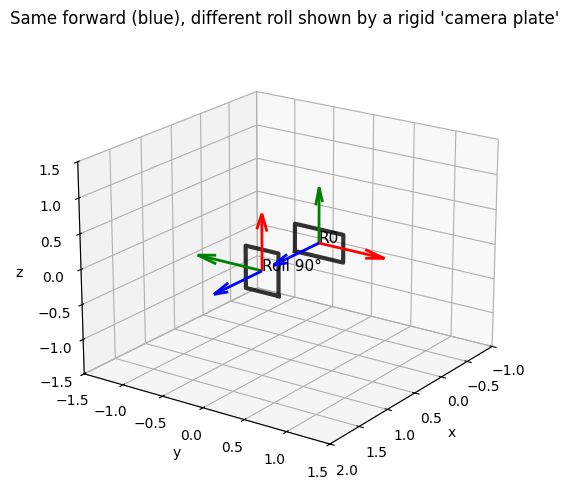

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def draw_frame(ax, R, p=np.zeros(3), L=0.8, label=None):
    colors = ['r','g','b']
    for i in range(3):
        v = R[:, i] * L
        ax.quiver(p[0], p[1], p[2], v[0], v[1], v[2], color=colors[i], linewidth=2)
    if label:
        ax.text(p[0], p[1], p[2], label, fontsize=11)

def draw_camera_plate(ax, R, p, w=0.6, h=0.4, d=0.0, alpha=0.25, color="k", label=None):
    """
    Draw a rectangle (camera sensor/phone screen) fixed to the body.
    The plate lies in the body x-y plane, with normal along body z (forward).
    """
    corners_b = np.array([
        [-w/2, -h/2, d],
        [ w/2, -h/2, d],
        [ w/2,  h/2, d],
        [-w/2,  h/2, d],
        [-w/2, -h/2, d],
    ], dtype=float)

    # transform to world: x_w = R * x_b + p
    corners_w = (R @ corners_b.T).T + p.reshape(1,3)
    ax.plot(corners_w[:,0], corners_w[:,1], corners_w[:,2],
            linewidth=3, color=color, alpha=alpha)

    if label:
        c = corners_w.mean(axis=0)
        ax.text(c[0], c[1], c[2], label, fontsize=10, color=color)


# --- assume you already have R0 and R_roll90 from the previous cell ---
p0 = np.array([0,0,0])
p1 = np.array([1.0,0,0])

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Same forward (blue), different roll shown by a rigid 'camera plate'")
ax.set_xlim(-1, 2); ax.set_ylim(-1.5, 1.5); ax.set_zlim(-1.5, 1.5)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=20, azim=35)

draw_frame(ax, R0, p0, label="R0")
# draw_camera_plate(ax, R0, p0, label="plate")
draw_camera_plate(ax, R0, p0, color="k", alpha=0.8)

draw_frame(ax, R_roll90, p1, label="Roll 90°")
# draw_camera_plate(ax, R_roll90, p1, label="plate")
draw_camera_plate(ax, R_roll90, p1, color="k", alpha=0.8)

plt.show()


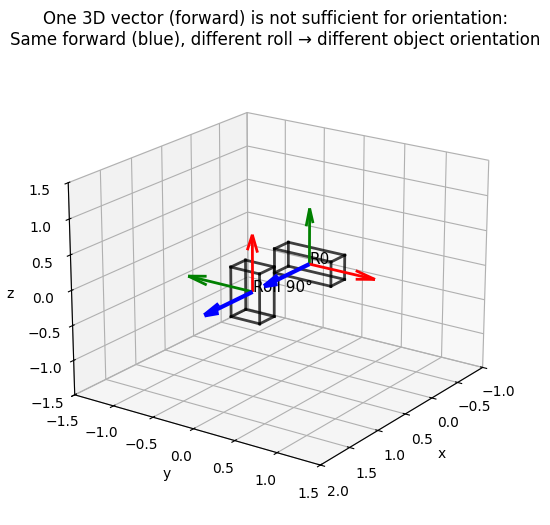

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def draw_frame(ax, R, p=np.zeros(3), L=0.8, label=None):
    colors = ['r','g','b']
    for i in range(3):
        v = R[:, i] * L
        lw = 3 if i == 2 else 2  # emphasize forward axis (blue)
        ax.quiver(p[0], p[1], p[2], v[0], v[1], v[2], color=colors[i], linewidth=lw)
    if label:
        ax.text(p[0], p[1], p[2], label, fontsize=11)

def draw_box(ax, R, p, w=0.6, h=0.35, d=0.25, color="k", alpha=0.6, linewidth=2.0, label=None):
    """
    Draw a 3D cuboid fixed to the body frame.
    Body axes: x (red), y (green), z (blue/forward).
    We center the box at the body origin and extend along +/- x,y,z.
    """
    # 8 corners in body coordinates
    x = w/2; y = h/2; z = d/2
    corners_b = np.array([
        [-x,-y,-z],
        [ x,-y,-z],
        [ x, y,-z],
        [-x, y,-z],
        [-x,-y, z],
        [ x,-y, z],
        [ x, y, z],
        [-x, y, z],
    ], dtype=float)

    # edges as pairs of corner indices
    edges = [
        (0,1),(1,2),(2,3),(3,0),  # bottom face
        (4,5),(5,6),(6,7),(7,4),  # top face
        (0,4),(1,5),(2,6),(3,7)   # verticals
    ]

    # transform corners to world
    corners_w = (R @ corners_b.T).T + p.reshape(1,3)

    # draw edges
    for i,j in edges:
        seg = np.vstack([corners_w[i], corners_w[j]])
        ax.plot(seg[:,0], seg[:,1], seg[:,2], color=color, alpha=alpha, linewidth=linewidth)

    if label:
        ax.text(p[0], p[1], p[2], label, fontsize=10, color=color)

# --- assume you already have R0 and R_roll90 from the previous cell ---
p0 = np.array([0,0,0])
p1 = np.array([1.0,0,0])

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

ax.set_title("One 3D vector (forward) is not sufficient for orientation:\nSame forward (blue), different roll → different object orientation")
ax.set_xlim(-1, 2); ax.set_ylim(-1.5, 1.5); ax.set_zlim(-1.5, 1.5)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=20, azim=35)

draw_frame(ax, R0, p0, label="R0")
draw_box(ax, R0, p0, w=0.7, h=0.35, d=0.25, color="k", alpha=0.75)

draw_frame(ax, R_roll90, p1, label="Roll 90°")
draw_box(ax, R_roll90, p1, w=0.7, h=0.35, d=0.25, color="k", alpha=0.75)

plt.show()


## How `rodrigues(axis, θ)` relates to the math

### Axis–angle (rotation in 3D)
A 3D rotation can be described by:
- a **unit axis** $\,\hat{\omega} \in \mathbb{R}^3\,$ (the line you rotate around)
- an **angle** $\,\theta \in \mathbb{R}\,$

This is called the **axis–angle** representation.

---

### The hat operator $[\cdot]_\times$
We convert a vector $\,\hat{\omega} = (\omega_x, \omega_y, \omega_z)\,$ into a skew-symmetric matrix:

$$
[\hat{\omega}]_\times =
\begin{bmatrix}
0 & -\omega_z & \omega_y \\
\omega_z & 0 & -\omega_x \\
-\omega_y & \omega_x & 0
\end{bmatrix}
$$

This matrix encodes cross products:

$$
[\hat{\omega}]_\times v \;=\; \hat{\omega} \times v
$$

---

### Rodrigues’ rotation formula (closed form)
The rotation matrix corresponding to “rotate by $\theta$ about axis $\hat{\omega}$” is:

$$
R(\hat{\omega}, \theta)
= I
+ \sin(\theta)\,[\hat{\omega}]_\times
+ (1-\cos(\theta))\,[\hat{\omega}]_\times^2
$$

In code, `rodrigues(axis, theta)` returns exactly this rotation matrix $R$.

---

### What this notebook demonstrates
A **single unit direction vector** (e.g., “forward”) lives on a sphere $S^2$ and has **2 DoF**.

A full 3D orientation is a rotation matrix $R \in SO(3)$ and has **3 DoF**.

So, many different rotations can share the same forward direction.  
We show this by applying a **roll** about the forward axis:

$$
R_{\text{roll}} = R(\hat{f}, \theta)\,R_0
$$

- $R_0$: base orientation  
- $\hat{f}$: the forward axis (unit vector)  
- $\theta$: roll angle (e.g., $90^\circ$)  
- $R_{\text{roll}}$ has the same forward axis as $R_0$, but a different **twist** about it.


In [3]:
def draw_camera_frustum(ax, R, p, depth=0.8, w=0.6, h=0.4, color="k", alpha=0.35):
    """
    Draw a simple camera frustum: 4 rays from camera center to image plane corners.
    Body z-axis is forward. Image plane is at +depth along body z.
    """
    # image plane corners in body coords at z=depth
    corners_b = np.array([
        [-w/2, -h/2, depth],
        [ w/2, -h/2, depth],
        [ w/2,  h/2, depth],
        [-w/2,  h/2, depth],
        [-w/2, -h/2, depth],
    ], dtype=float)

    # transform corners to world
    corners_w = (R @ corners_b.T).T + p.reshape(1,3)

    # camera center
    c = p.reshape(1,3)

    # draw image plane rectangle
    ax.plot(corners_w[:,0], corners_w[:,1], corners_w[:,2],
            linewidth=2.5, color=color, alpha=alpha)

    # draw 4 rays from center to corners (skip the repeated last point)
    for i in range(4):
        seg = np.vstack([c, corners_w[i:i+1]])
        ax.plot(seg[:,0], seg[:,1], seg[:,2], color=color, alpha=alpha)


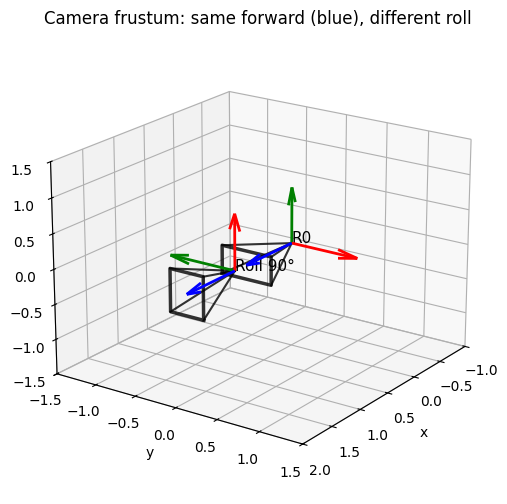

In [4]:
# --- choose your two poses (must already exist) ---
# Expecting these variables to already exist from earlier cells:
# R0, R_roll90 (or whatever you named it), p0, p1

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

ax.set_title("Camera frustum: same forward (blue), different roll")
ax.set_xlim(-1, 2); ax.set_ylim(-1.5, 1.5); ax.set_zlim(-1.5, 1.5)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=20, azim=35)

draw_frame(ax, R0, p0, label="R0")
draw_camera_frustum(ax, R0, p0, color="k", alpha=0.8)

draw_frame(ax, R_roll90, p1, label="Roll 90°")
draw_camera_frustum(ax, R_roll90, p1, color="k", alpha=0.8)

plt.show()


# draw_camera_frustum(ax, R0, p0, color="k", alpha=0.8)
# draw_camera_frustum(ax, R_roll90, p1, color="k", alpha=0.8)


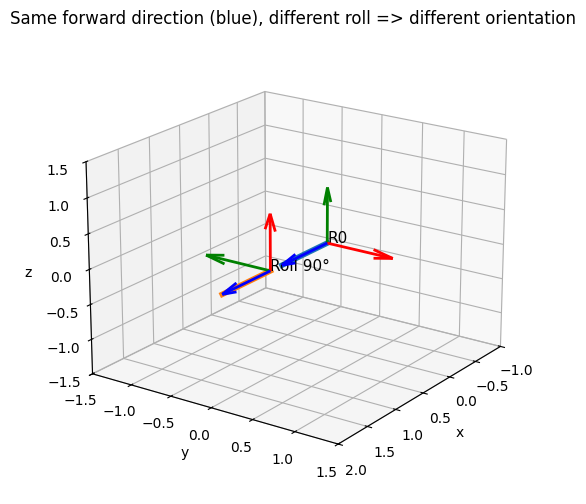

In [5]:

# Plot them
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Same forward direction (blue), different roll => different orientation")
ax.set_xlim(-1, 2); ax.set_ylim(-1.5, 1.5); ax.set_zlim(-1.5, 1.5)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=20, azim=35)

draw_frame(ax, R0, p=np.array([0,0,0]), L=0.8, label="R0")
draw_frame(ax, R_roll90, p=np.array([1.0,0,0]), L=0.8, label="Roll 90°")

# draw the forward vectors for emphasis (blue axis)
ax.plot([0, R0[0,2]*0.8], [0, R0[1,2]*0.8], [0, R0[2,2]*0.8], linewidth=4)
ax.plot([1.0, 1.0 + R_roll90[0,2]*0.8], [0, R_roll90[1,2]*0.8], [0, R_roll90[2,2]*0.8], linewidth=4)

plt.show()
